# **Data Visualization**
---

## Objective

- Answer business requirement 1:
    * The client is interested in a recommendation regarding the scale and quality of future datasets as well as an investigation of a correlation between the similarity of the pets' visual features and the performance of the model.

## Inputs

- The folder `inputs/datasets/pets` containing the subfolders `train`, `test`, and `validation`
- The correctly labelled folders in each of these subfolders
- An adequate amount of preprocessed png images (size 128x128) in each labelled folder, showing a snapshot of a pet coming up to a bowl
- The file `class_dict.pkl` containing the indexed classes

## Outputs

- Image shape pickle file
- Mean and Variance images for each label
- Histograms showing the differences between the means
- Code that answers business requirement 1 and can be used to build an image montage on the Streamlit dashboard

---
## Preparation
### Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tensorflow.keras.preprocessing import image
from PIL import Image
import random
import cv2

sns.set_style("white")

### Set the correct working directory

In [2]:
# Check the current working directory
cwd = os.getcwd()
cwd

'd:\\Projekte\\Coding\\CodeInstitute\\PP5\\jupyter_notebooks'

In [3]:
# Move up to the project top directory
os.chdir(os.path.dirname(cwd))
cwd = os.getcwd()
cwd

'd:\\Projekte\\Coding\\CodeInstitute\\PP5'

### Set the main paths and constant variables

It was decided that the input shape of the images that the model will be trained on shall be (128, 128, 3).

In [4]:
from src.utils_notebooks import (print_err, show_progress, set_ticks,
                                 font_props)

font_top, title_props_box, title_props = font_props()

dataset_name = "pets"
full_dataset_path = os.path.normpath(
    os.path.join(cwd, "inputs/datasets", dataset_name))
output_path = os.path.join(cwd, "outputs")
train_path = os.path.join(full_dataset_path, "train")
test_path = os.path.join(full_dataset_path, "test")
validation_path = os.path.join(full_dataset_path, "validation")

INPUT_SHAPE = (-1, 128, 128, 3)
joblib.dump(INPUT_SHAPE, f"{output_path}/input_shape.pkl")
LABELS = sorted(joblib.load(f"{output_path}/class_dict.pkl").values())

SAVE = False

os.listdir(full_dataset_path)

['test', 'train', 'validation']

---
## Step 1
### Show image montage

Let's take a look at our dataset to make sure it is useable.

In [19]:
import itertools


def show_montage(nrows, ncols, labels):
    """Generate and display an image montage with images from the train dataset

    Args:
        nrows (int): Amount ow rows to fill
        ncols (int): Amount of columns to fill
        labels (list): Labels to display
    """

    list_rows = range(0, nrows)
    list_cols = range(0, ncols)
    plot_idx = list(itertools.product(list_rows, list_cols))

    for label in labels:
        label_path = os.path.join(train_path, label)
        label_files = os.listdir(label_path)
        rnd_sample = random.sample(label_files, nrows * ncols)

        _, axes = plt.subplots(
            nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 5)
        )
        for idx, img in enumerate(rnd_sample):
            img = np.asarray(Image.open(os.path.join(label_path, img))) / 255.0
            axes[plot_idx[idx][0], plot_idx[idx][1]].imshow(img)
            set_ticks(axes[plot_idx[idx][0], plot_idx[idx][1]])

        plt.suptitle(t=f"\n{label.upper()}:\n",
                     fontproperties=font_top, **title_props)
        plt.axis("off")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

### Display the montage.

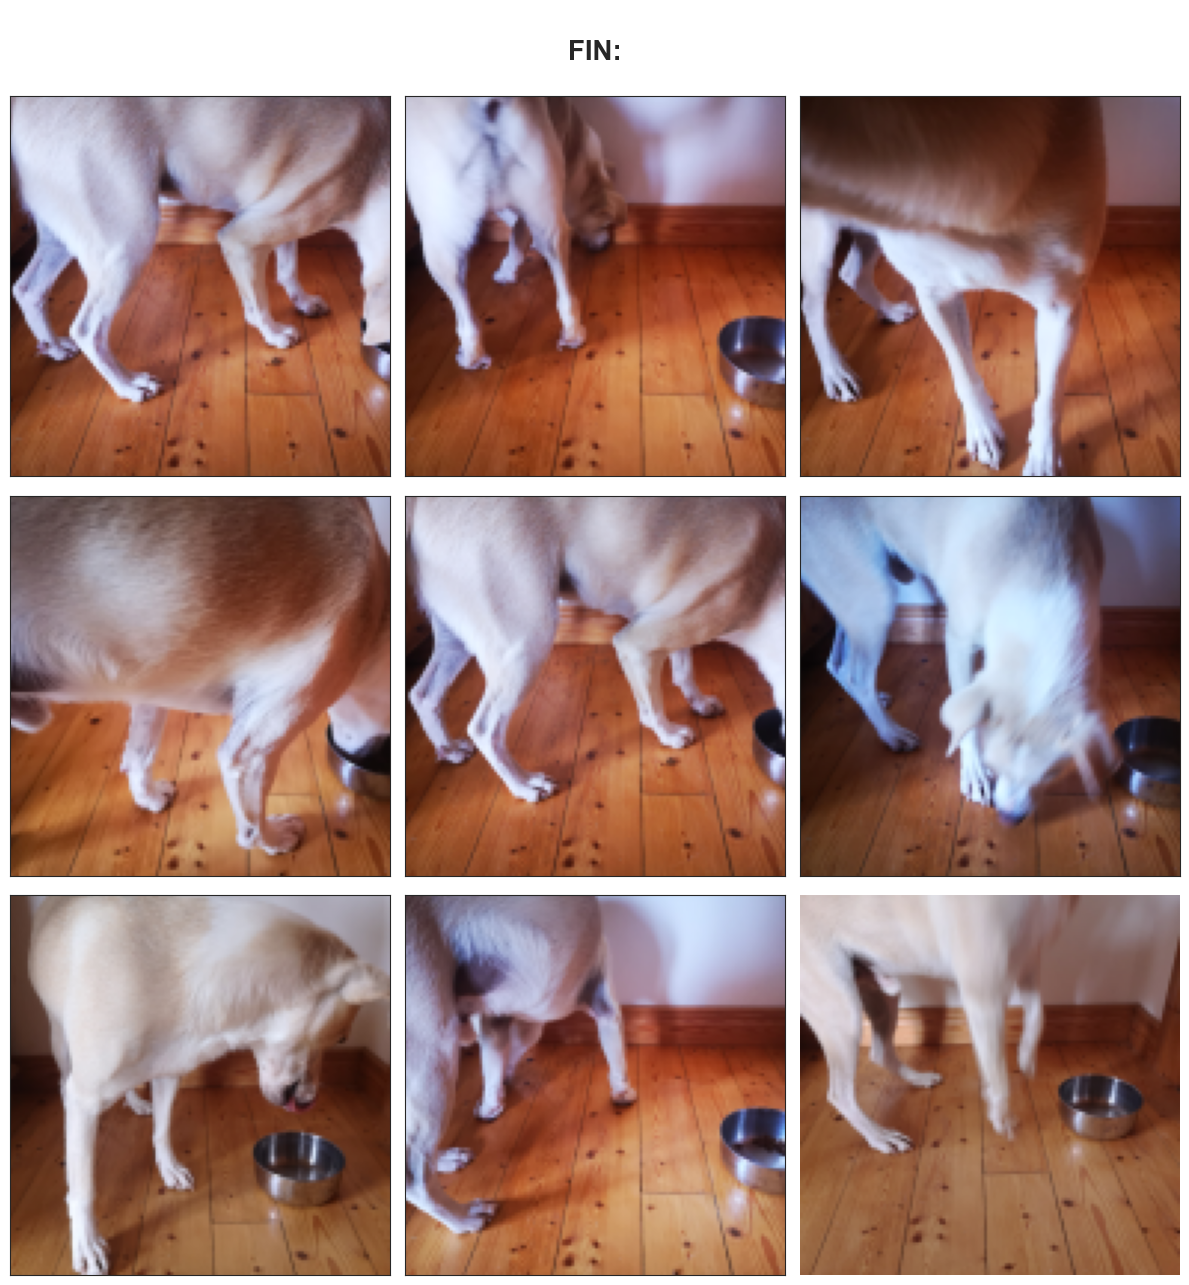

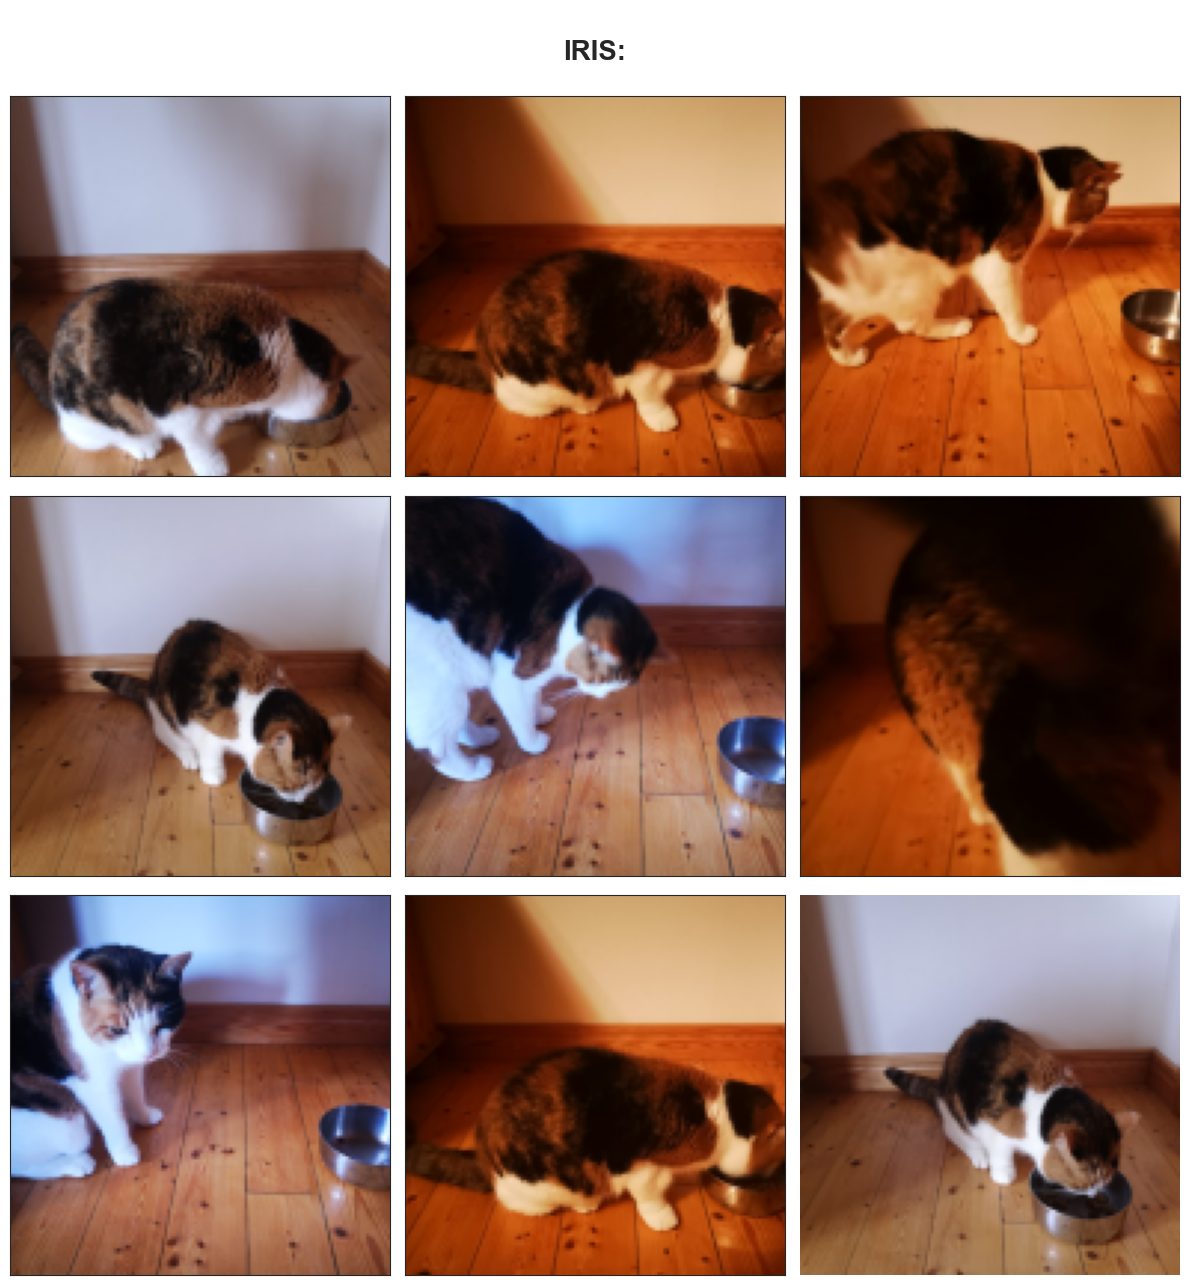

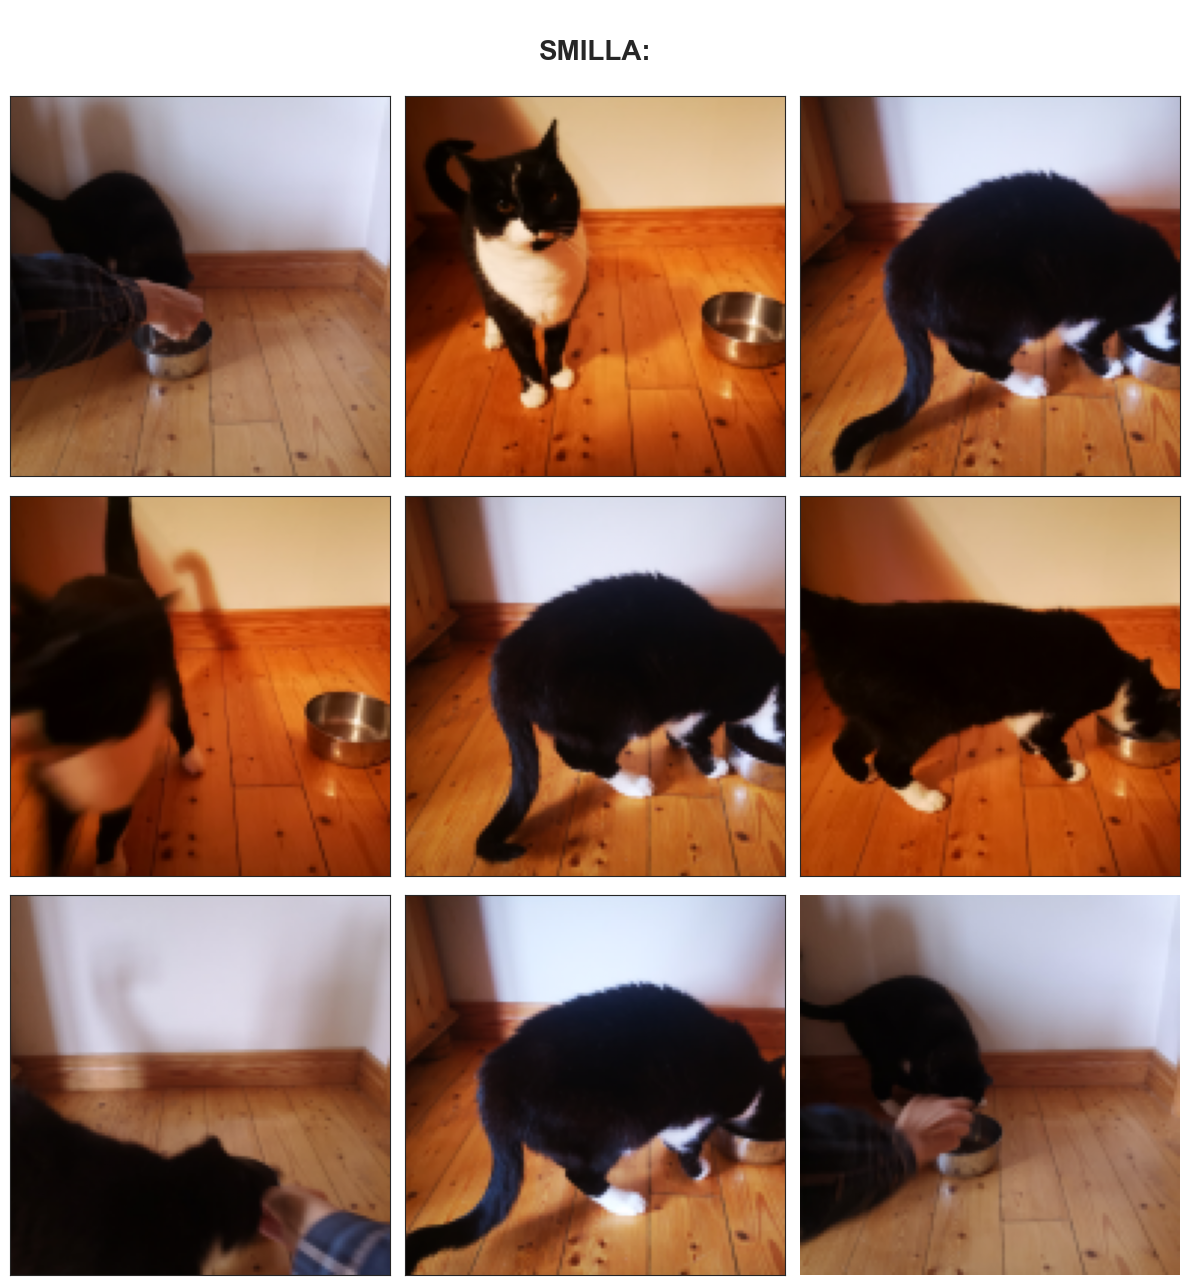

In [7]:
show_montage(3, 3, LABELS)

## Step 2
### Load image sample for visualization

Function to load all images into an array

In [5]:
from PIL.Image import UnidentifiedImageError

def create_img_array(path, amount, shape):
    Xy_dict = {}
    dims = shape[1:3]
    for label in os.listdir(path):
        label_path = os.path.join(path, label)
        # Select a given amount of random images from the provided folder
        img_list = random.sample(
            os.listdir(label_path), min(amount, len(os.listdir(label_path)))
        )
        
        Xy_dict[label] = np.array([], dtype="int")

        print(f'\nImporting from label "{label}..."')
        progress_bar = show_progress(len(img_list))
        img_counter = 0
        errors = []

        for img_name in img_list:
            try:
                img = image.load_img(os.path.join(path, label, img_name))
            except UnidentifiedImageError as e:
                errors.append(f"{e} :: {img_name} >> skipped")
                continue
            
            if img.size != (dims):
                img = img.resize(dims, resample=Image.LANCZOS)
            
            img_resized = image.img_to_array(img)
            if len(img_resized.shape) == 3 and img_resized.shape[-1] != 3:
                errors.append(
                    f"Image does not seem to have 3 channels :: "
                    f"{os.path.join(path, label, img_name)} >> skipped")
            
            if img_resized.max() > 1:
                img_resized = img_resized / 255.0

            img_counter += 1
            Xy_dict[label] = np.append(Xy_dict[label], img_resized)

            print(next(progress_bar), end="")

        # Exhaust the progress bar generator
        try:
            rest = [p for p in progress_bar]
            print("".join(rest), end="")
        except StopIteration:
            pass

        print(f"{img_counter} images loaded")
        if errors:
            print_err("\n".join(errors))

        temp = list(Xy_dict[label].reshape(shape).astype('float32'))
        random.shuffle(temp)
        Xy_dict[label] = np.array(temp)

    print("\nImage data loaded.")

    return Xy_dict


Load sample images into a file and check if they have been loaded correctly.


Importing from label "fin..."
: ####################################################################################################|| 246 images loaded

Importing from label "iris..."
: ####################################################################################################|| 360 images loaded

Importing from label "smilla..."
: ####################################################################################################|| 268 images loaded

Image data loaded.

Shape of label iris: (360, 128, 128, 3)


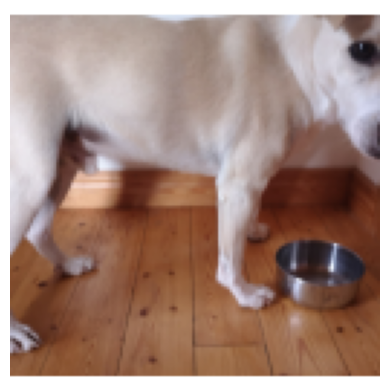

In [6]:
img_path = os.path.join(full_dataset_path, "train")
X_y_sample = create_img_array(img_path, 360, INPUT_SHAPE)

rnd_label = random.choice(list(X_y_sample.keys()))
print(f"\nShape of label {rnd_label}: {X_y_sample.get(rnd_label).shape}")
plt.imshow(random.choice(X_y_sample.get('fin')))
plt.axis("off")
plt.show()


## Step 3
### Show average images for each label

First, we create a dictionary containing the mean images for each label.

In [13]:
# Create a dictionary with the mean images of all labels
import itertools
from skimage.color import rgb2gray

def get_means(X, labels):
    """Return Mean and Var images for each label

    Args:
        X (dict): Dictionary with images, sorted by label
        labels (list): List with the labels

    Returns:
        dict: Dictionary with all Mean, Var, and Var_norm images
    """

    compound_dict = {"means": {}, "vars": {}, "vars_norm": {}}

    for label in labels:
        X_mean = np.mean(X[label], axis=0)
        X_var = np.var(X[label], axis=0)*2
        X_var_norm = rgb2gray(np.var(X[label], axis=0))

        compound_dict["means"][label] = X_mean
        compound_dict["vars"][label] = X_var
        compound_dict["vars_norm"][label] = X_var_norm
        
    return compound_dict

In [14]:
compound_dict = get_means(X_y_sample, LABELS)

Then we display the mean image for each label.

In [14]:
def calc_figure(amount):
    """Util function to calculate figure size depending on label amount

    Args:
        labels (list): List with all label names

    Returns:
        int: Amount of columns
        int: Amount of rows
        list: Coordinates for all label mean images
    """

    if (amount % 3 == 0 and amount % 2 == 0 and amount % 4 != 0) or (
        amount % 3 == 0 and amount <= 6
    ):
        ncols = 3
    elif amount == 2:
        ncols = 2
    else:
        ncols = max(min(2, amount + (amount % 3)), 4)

    nrows = max(1, (1 if amount % ncols != 0 else 0) + amount // ncols)

    if amount - ncols == 1 or amount - ncols * (nrows - 1) == 1:
        ncols = 3
        nrows = max(1, (1 if amount % ncols != 0 else 0) + amount // ncols)

    coords = list(itertools.product(range(nrows), range(ncols)))[:amount]

    return ncols, nrows, coords


def show_means(img_dict, img_type, labels, save=False):
    """Display the mean image for each label in a grid

    Args:
        img_dict (dict): Dictionary with mean or variance images as numpy arrays
        labels (list): list with all label names
    """
        
    ncols, nrows, coords = calc_figure(len(labels))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5))
    # Hide the axes of unused plots
    for ax in axes:
        if nrows == 1:
            ax.set_axis_off()
        else:
            for plot in ax:
                plot.set_axis_off()

    for idx, coord in enumerate(coords):
        if nrows > 1:
            axes[coord[0]][coord[1]].set_title(
                f"{img_type} image for label {labels[idx]}", fontweight="bold"
            )
            axes[coord[0]][coord[1]].imshow(img_dict[labels[idx]], cmap='gray')
            set_ticks(axes[coord[0]][coord[1]])
        else:
            axes[idx].set_title(
                f"{img_type} image for label {labels[idx]}", fontweight="bold"
            )
            axes[idx].imshow(img_dict[labels[idx]], cmap='gray')
            set_ticks(axes[idx])
    
    if SAVE:
        plt.savefig(
            f"{output_path}/{img_type.lower().replace(' ', '_')}_images_grid.png",
            bbox_inches="tight",
            dpi=150,
        )
    plt.show()

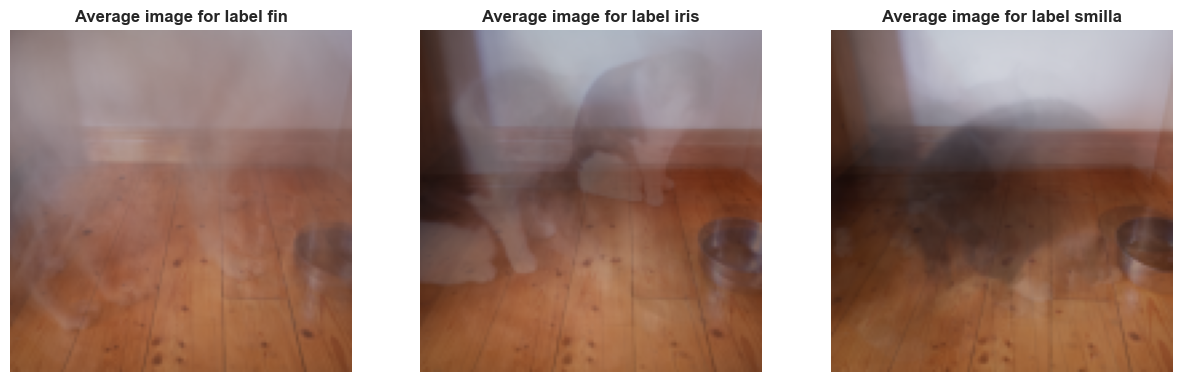

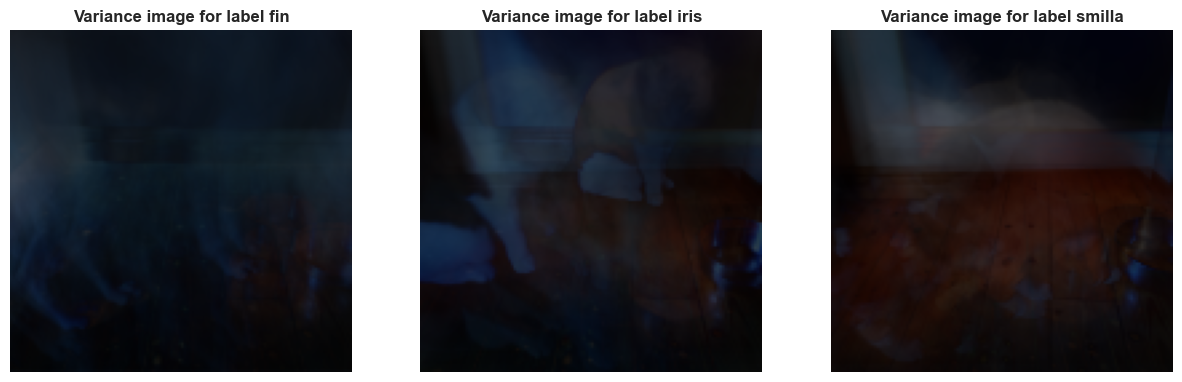

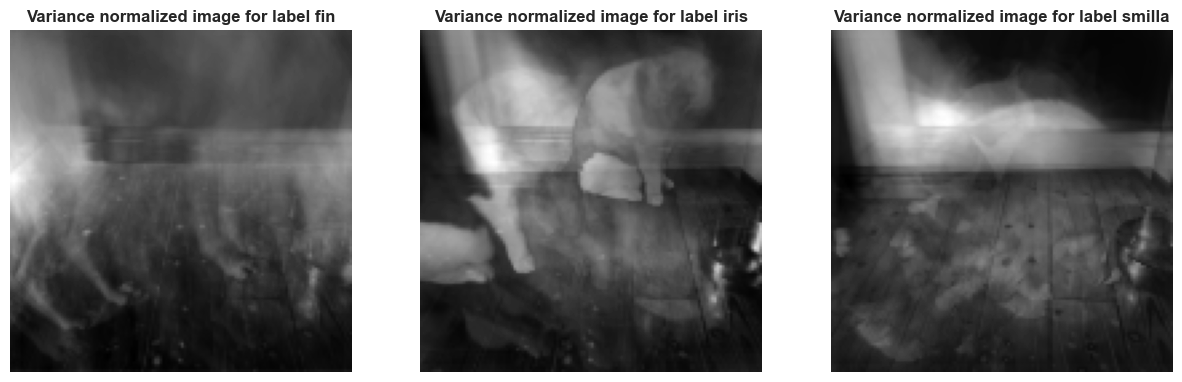

In [15]:
show_means(compound_dict["means"], "Average", LABELS)
show_means(compound_dict["vars"], "Variance", LABELS)
show_means(compound_dict["vars_norm"], "Variance normalized", LABELS)


The images seem distinguishable from each other. However, we want to be able to make a recommendation based on an explicit number or graph that will show whether our model architecture is suitable for the given image sets.
Before we start comparing mean images, we make sure to collect all metrics when histograms are being compared to each other.

In [15]:
import math

def collect_metrics(hist_1, hist_2, label, comp_results):
    # Adapted from https://www.geeksforgeeks.org/measure-similarity-between-images-using-python-opencv/
    # and https://pyimagesearch.com/2014/07/14/3-ways-compare-histograms-using-opencv-python/
    
    methods = {
        'Correlation (high=sim)': cv2.HISTCMP_CORREL,
        'Chi-Squared (low=sim)': cv2.HISTCMP_CHISQR,
        'Intersection (high=sim)': cv2.HISTCMP_INTERSECT,
        'Bhattacharyya (low=sim)': cv2.HISTCMP_BHATTACHARYYA
    }
    rgb_dict = {0: ' | R', 1: ' | G', 2: ' | B'}
    label = ' - '.join([l.capitalize() for l in label[:2]]) + rgb_dict[label[2]]
    comp_results.setdefault(label, {})

    for method_name, method in methods.items():
        comparison = cv2.compareHist(hist_1, hist_2, method)
        comp_results[label][method_name.split(" ")[0]] = float(comparison)

    # Euclidean Distance
    c = np.linalg.norm(hist_1-hist_2)
    
    comp_results[label]['Euclidean Distance'] = c

    return comp_results

In the next cell, we use `cv2.calcHist` to calculate histograms for each color channel of the two images that will be compared , normalize them together on the same scale between 0 and 1 and plot them for visualization.

In [16]:
def show_hist(img_1, img_2, img_type, labels, comp_results):
    """Generate histograms for each color channel and compare them"""

    _, axes = plt.subplots(nrows=1, ncols=3, figsize=(17, 6))
    plt.suptitle(
        f"{img_type.capitalize()} histograms by color channel"
        f"{f': {labels[0]}' if labels[0] == labels[1] else f': {labels[0]} - {labels[1]}'}",
        fontproperties=font_top,
        **title_props_box,
    )

    bins = 100
    ylim_min, ylim_max = 1.05, -1
    hist_data = []

    # Concatenate the histograms of all 3 channels of both images into one list, 
    # normalize them together to preserve the differences between channels
    for img in [img_1, img_2]:
        for ch in [0, 1, 2]:
            data = (img[..., ch]).flatten()
            hist = cv2.calcHist([data], [0], None, [bins], [0, 1.1])
            hist = hist.flatten()
            hist_data.extend(hist)

    # Expected shape is (bins*6, 1) because we have 2 images with 3 channels 
    # each
    hist_data = np.array(hist_data).reshape(-1, 1)
    # Reshape into 6 layers with [bins] elements each; expected shape:
    # (6, bins, 1)
    hist_data_norm = cv2.normalize(hist_data, hist_data, alpha=0, beta=1, 
                                   norm_type=cv2.NORM_MINMAX).reshape(
                                                                -1, bins, 1)
    
    ch_dict = {2: 0, 1: 0, 0: 0}
    
    for ax, img in zip(axes[:2], [0, 3]):
        for ch, col in zip([2, 1, 0], ["b", "g", "r"]):
            layer = hist_data_norm[img+ch].flatten()
            # Save difference between two histograms of the same channel
            # to show in the 3rd plot.
            ch_dict[ch] = layer - ch_dict[ch]
            ax = sns.barplot(ax=ax, x=np.arange(0, len(layer), 1), y=layer,
                             color=col, width=1, alpha=0.4)
            ax.set_xlim(0, len(layer))
            ax.set_xticks(np.arange(0, len(layer)+1, 20))
            ylim_max = max(ylim_max, max(layer)+0.05)
            ylim_min = min(ylim_min, min(layer))

    for ax in axes[:2]:
        ax.set_ylim(ylim_min, ylim_max)
        ax.grid(True)
    axes[0].set_title(f"{img_type.capitalize()} histogram {f'of {labels[0]}' if labels[0] != labels[1] else '1'}")
    axes[1].set_title(f"{img_type.capitalize()} histogram {f'of {labels[1]}' if labels[0] != labels[1] else '2'}")

    # Plot the histogram diffs by channel
    layers = sorted(ch_dict.items(), key=lambda x: x[0], reverse=True)
    for (_, layer), ch, col in zip(layers, [2, 1, 0], ['b', 'g', 'r']):
        sns.barplot(ax=axes[2], x=np.arange(0, len(layer), 1), y=layer, 
                                            color=col, width=1, alpha=0.4)
    axes[2].set_xlim(0, len(layer))
    axes[2].set_xticks(np.arange(0, len(layer)+1, 20))
    axes[2].set_ylim(-1.05, 1.05)
    axes[2].set_title(f"{img_type.capitalize()} histogram comparison")
    axes[2].grid(True)

    plt.subplots_adjust(top=0.8)

    save_str = (
        f"hist_baseline_{img_type}_{labels[0]}_rgb.png"
        if labels[0] == labels[1]
        else f"hist_{img_type}_{labels[0]}_{labels[1]}_rgb.png"
    )
    if SAVE:
        plt.savefig(f"{output_path}/{save_str}", bbox_inches="tight", dpi=150)
    plt.show()

    for ch in [0, 1, 2]:
        comp_results.update(
            collect_metrics(
                hist_data_norm[ch], hist_data_norm[ch+3], (labels[0], labels[1], ch),
                comp_results))

    return comp_results


We look for a baseline that shows the differences between very similar images. To that end, we split the image arrays of each label in half and compare both halves to each other. The idea is to get values from the comparison methods that show the high similarity between two images. We can then use them as a baseline and compare them to the values produced by comparing different images, thereby creating a scale for all comparisons. 

In [17]:

def find_baseline(X, labels):
    """Create baseline images"""
    
    comp_results={}

    for label in labels:
        
        mid_idx = int(len(X[label]) // 2)
        arr_1, arr_2 = X[label][:mid_idx], X[label][mid_idx:]        
        mean_1 = np.mean(arr_1, axis=0)
        mean_2 = np.mean(arr_2, axis=0)
        mean_diff = abs(cv2.subtract(mean_1, mean_2))*2

        mean_diff_norm = cv2.cvtColor(mean_diff, cv2.COLOR_RGB2GRAY)
        
        _, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
        plt.suptitle(
            f"Average images for # {label} # and the difference between them",
            fontproperties=font_top,
            **title_props_box,
        )
        for ax, img in zip(axes, [mean_1, mean_2, mean_diff, mean_diff_norm]):
            ax.imshow(img, cmap='gray')
            set_ticks(ax)

        if SAVE:
            plt.savefig(f"{output_path}/baseline_imgs_{label}.png", bbox_inches="tight", dpi=150)
        plt.show()

        # Show average histograms and plot the differences
        comp_results = show_hist(mean_1, mean_2, "average", [label, label], comp_results)

    return comp_results


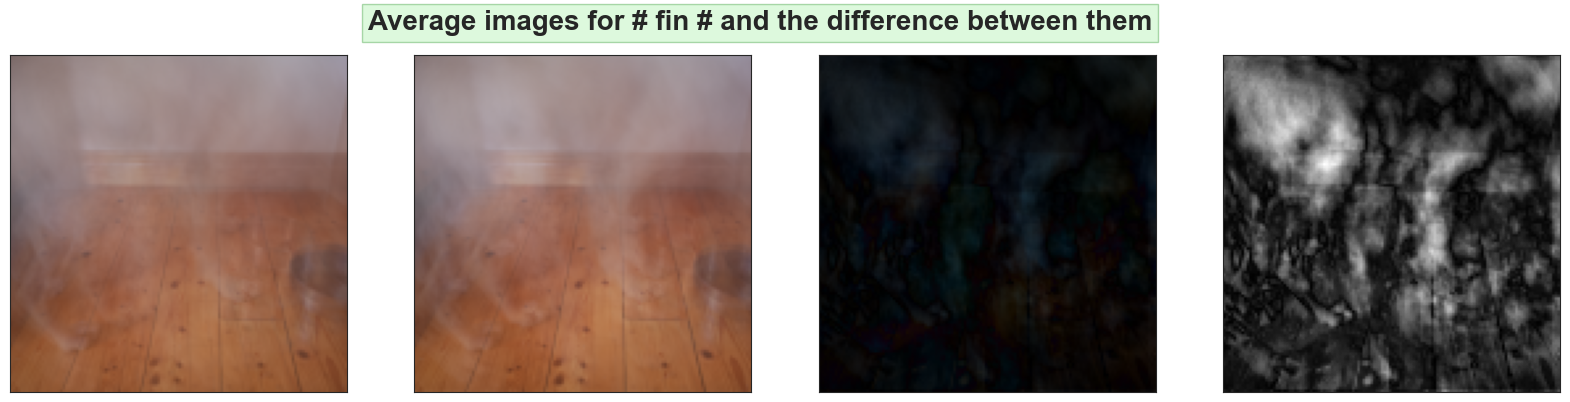

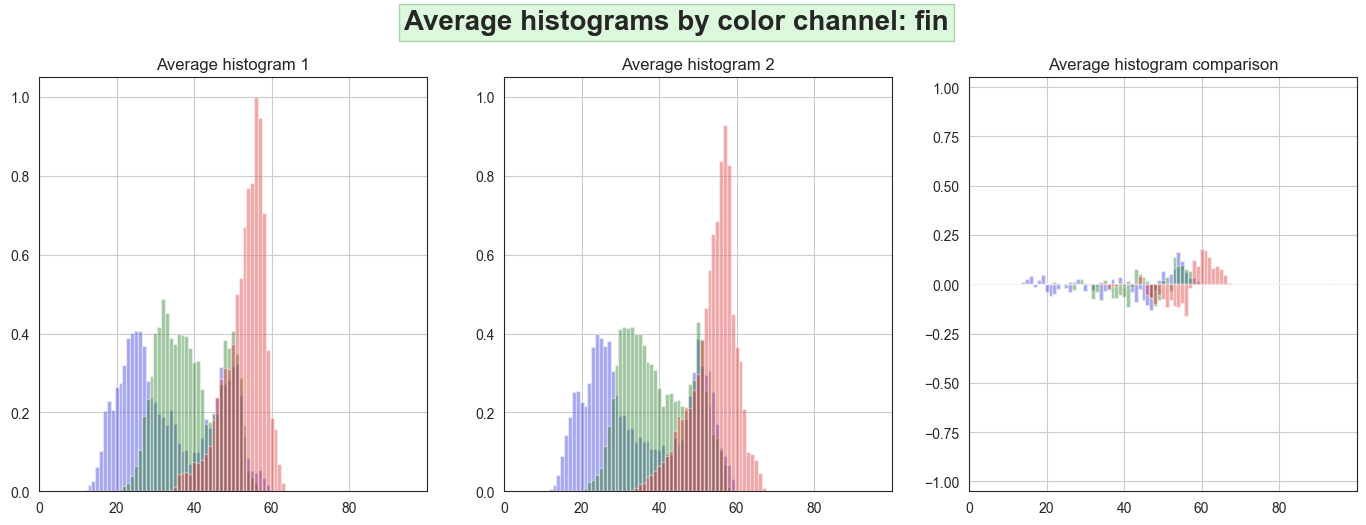

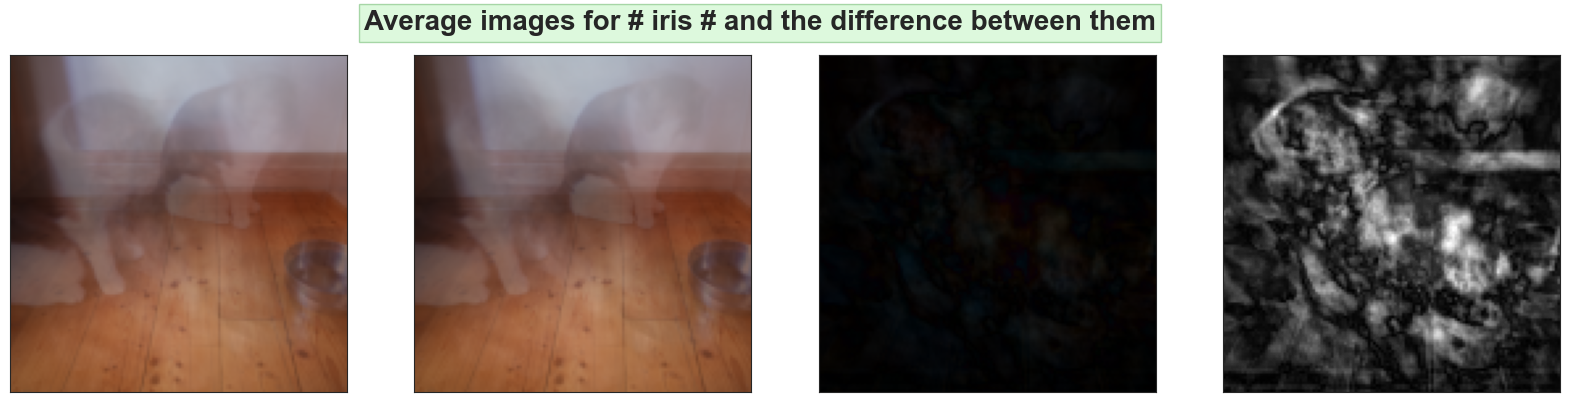

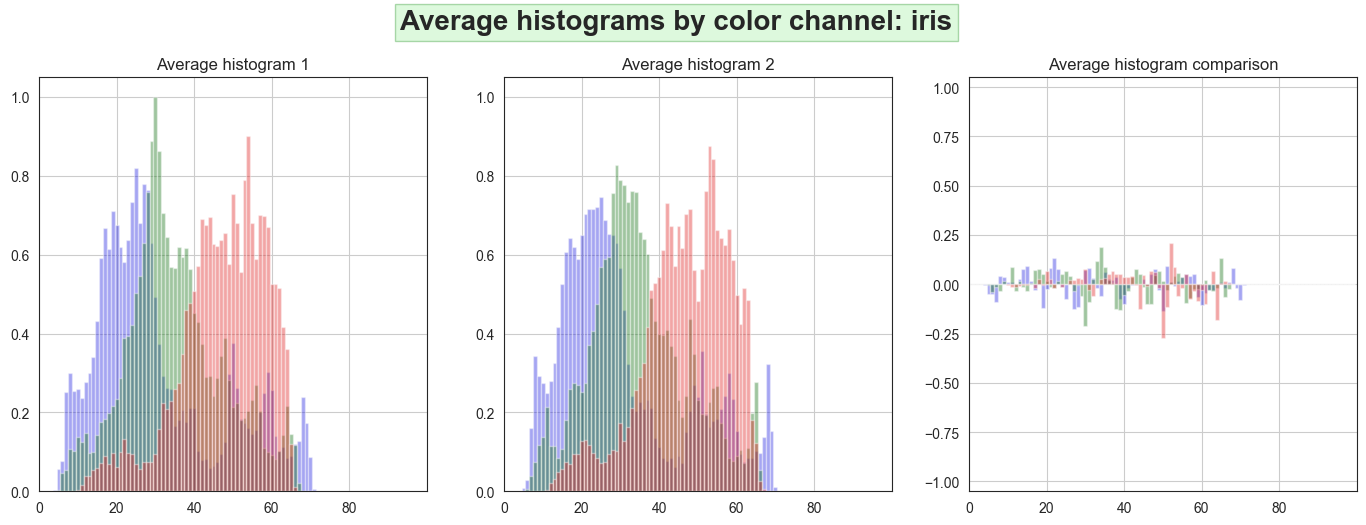

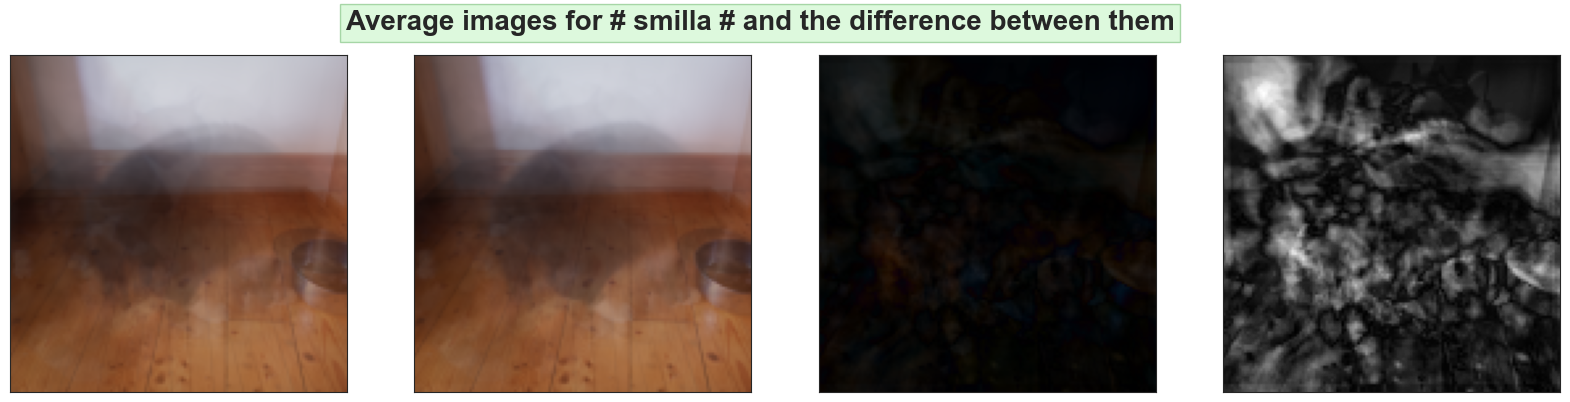

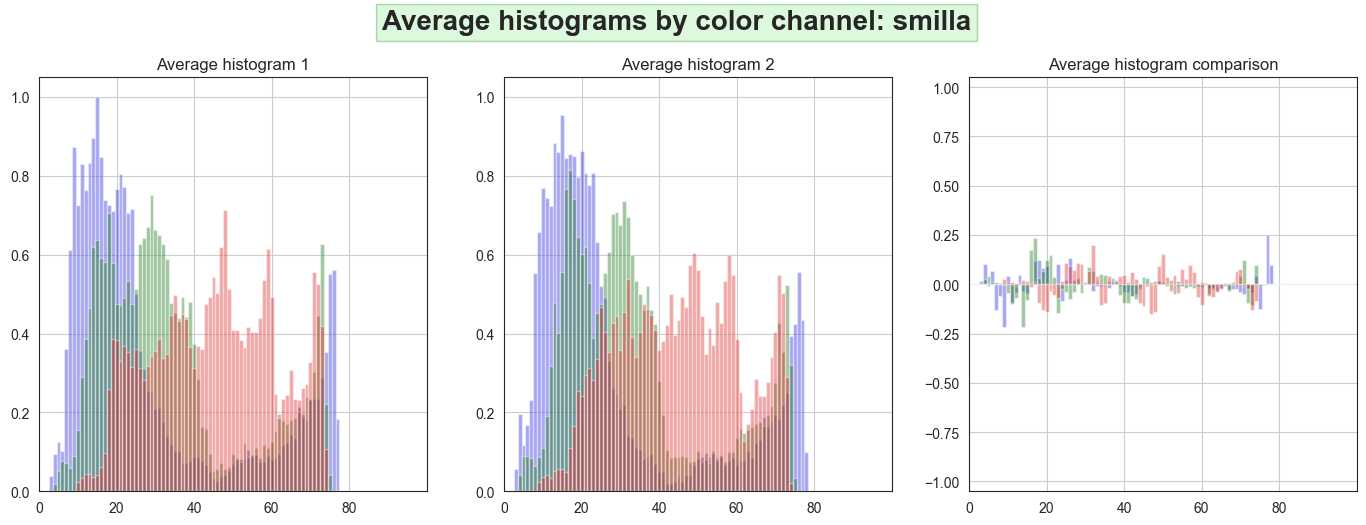

In [18]:
comp_results = find_baseline(X_y_sample, LABELS)

The histogram diffs show very little difference between the mean images of the same label.<br>
We now compare the mean images of different labels to each other.<br>
We also calculate the `np.mean` and  `np.var` values for the diff image, hoping to discern a trend in similarity values that we can later contrast with our actual training results and the misclassification data of each pet pair.

In [21]:
def compare_labels(labels, comp_dict, comp_results):
    """Compare all label means"""
    
    combos = list(itertools.combinations(labels, 2))

    for combo in combos:

        mean_1 = comp_dict["means"][combo[0]]
        mean_2 = comp_dict["means"][combo[1]]
        mean_diff = abs(cv2.subtract(mean_1, mean_2))
    
        print(f"Mean for {combo}: ", np.mean(mean_diff))
        print(f"Variance for {combo}", np.var(mean_diff))

        mean_diff_norm = cv2.cvtColor(mean_diff, cv2.COLOR_RGB2GRAY)
        
        _, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
        plt.suptitle(
            f"Average images for {combo[0]} and {combo[1]} and the difference "
            f"between them",
            fontproperties=font_top,
            **title_props_box,
        )

        for ax, img in zip(axes, [mean_1, mean_2, mean_diff, mean_diff_norm]):
            ax.imshow(img, cmap="gray")
            set_ticks(ax)
        if SAVE:
            plt.savefig(
                f"{output_path}/average_imgs_{combo[0]}_{combo[1]}.png",
                bbox_inches="tight",
                dpi=150,
            )
        plt.show()

        # Show average histograms and plot the differences
        comp_results = show_hist(mean_1, mean_2, "average", 
                                 [combo[0], combo[1]], comp_results)

      
    return comp_results


Mean for ('fin', 'iris'):  0.08560952
Variance for ('fin', 'iris') 0.0073880223


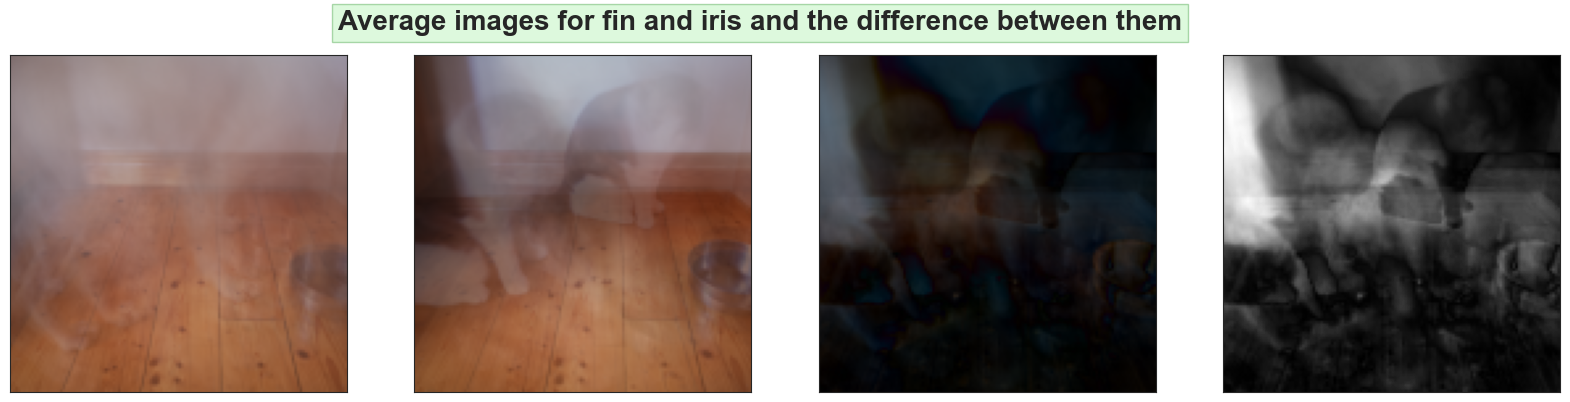

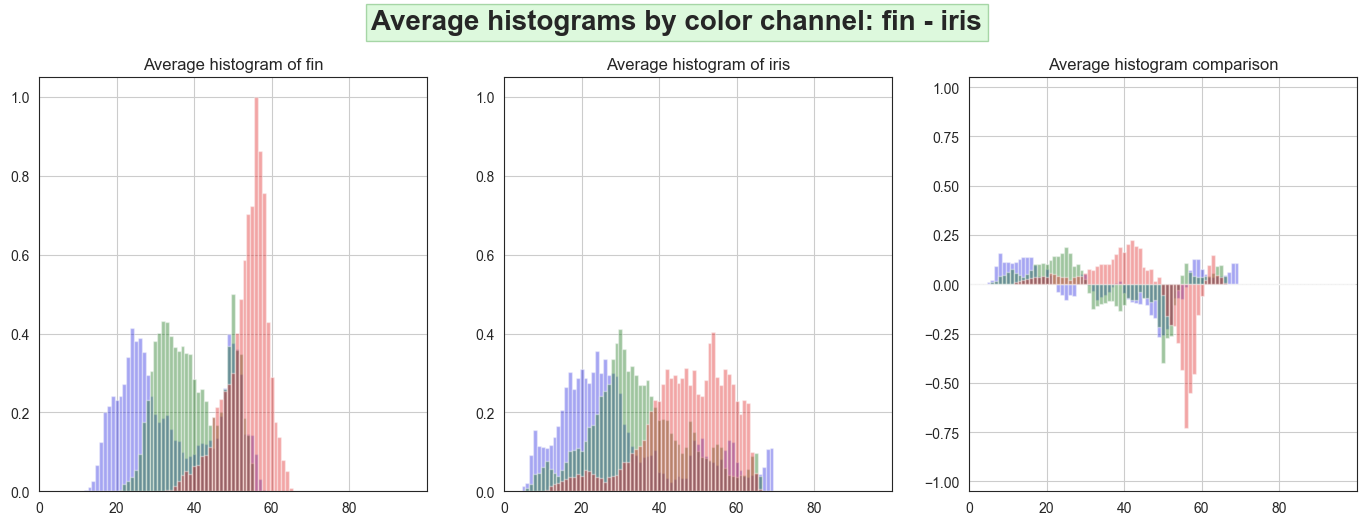

Mean for ('fin', 'smilla'):  0.14524247
Variance for ('fin', 'smilla') 0.010799233


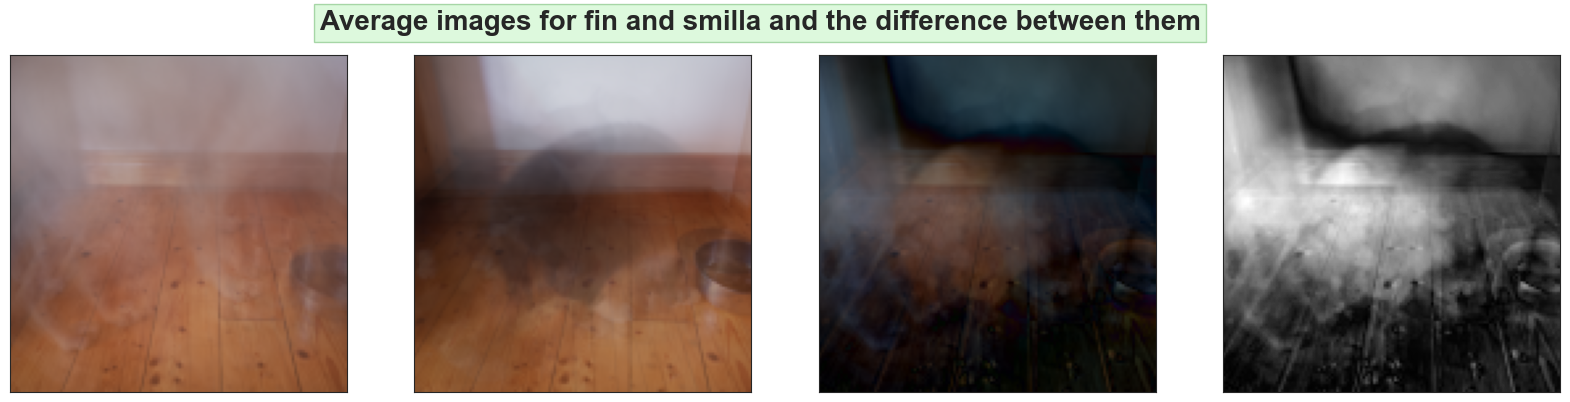

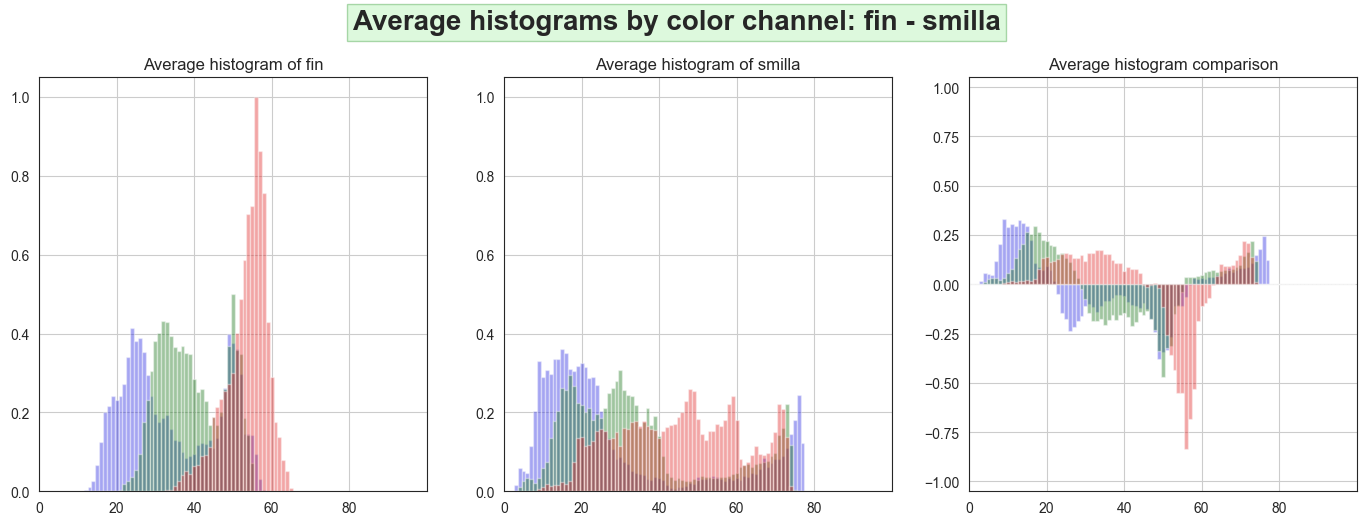

Mean for ('iris', 'smilla'):  0.08883532
Variance for ('iris', 'smilla') 0.004014945


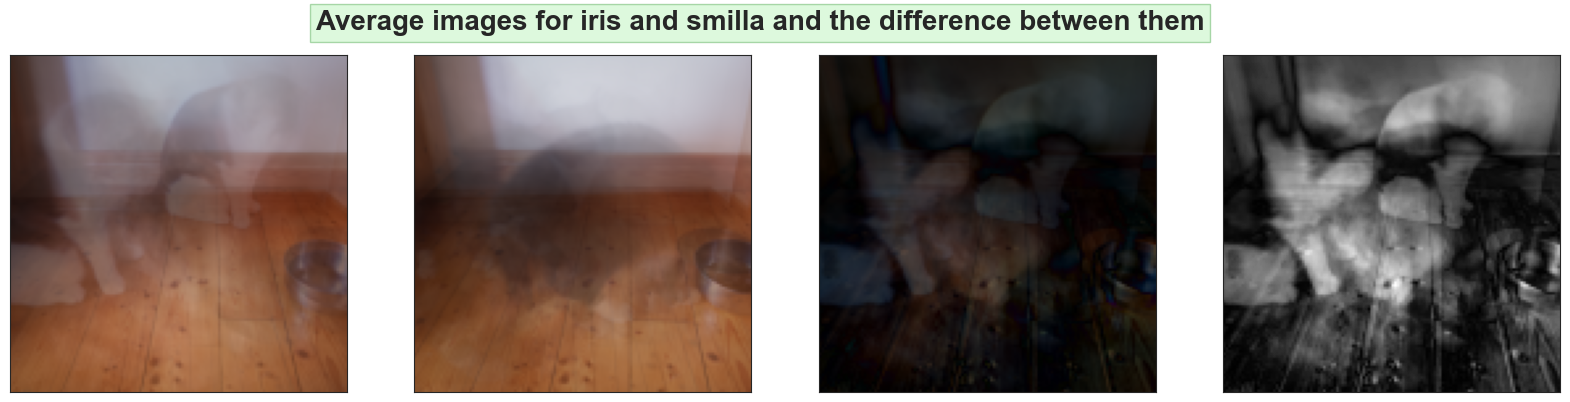

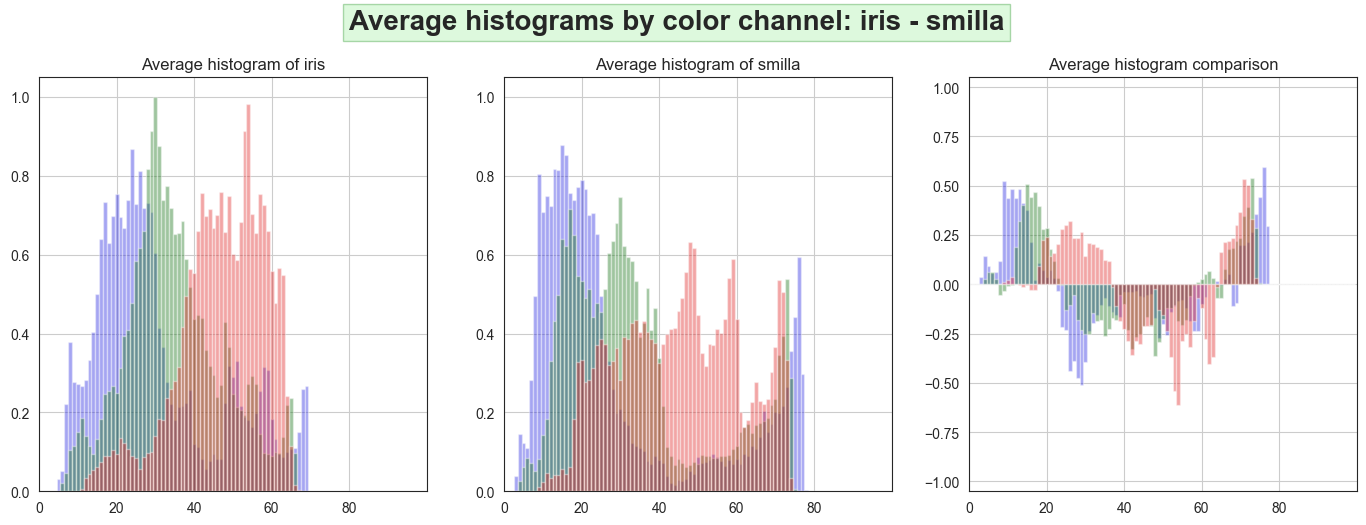

In [22]:
comp_results.update(compare_labels(LABELS, compound_dict, comp_results))

The variance values for the mean diffs show a discernible trend, with Fin-Smilla being most different and Iris-Smilla most alike.<br>
We will note these values for later reference.

Next, we create a heatmap for all compared pairs by label and channel. We want to see how each comparison method has evaluated the respective pair.

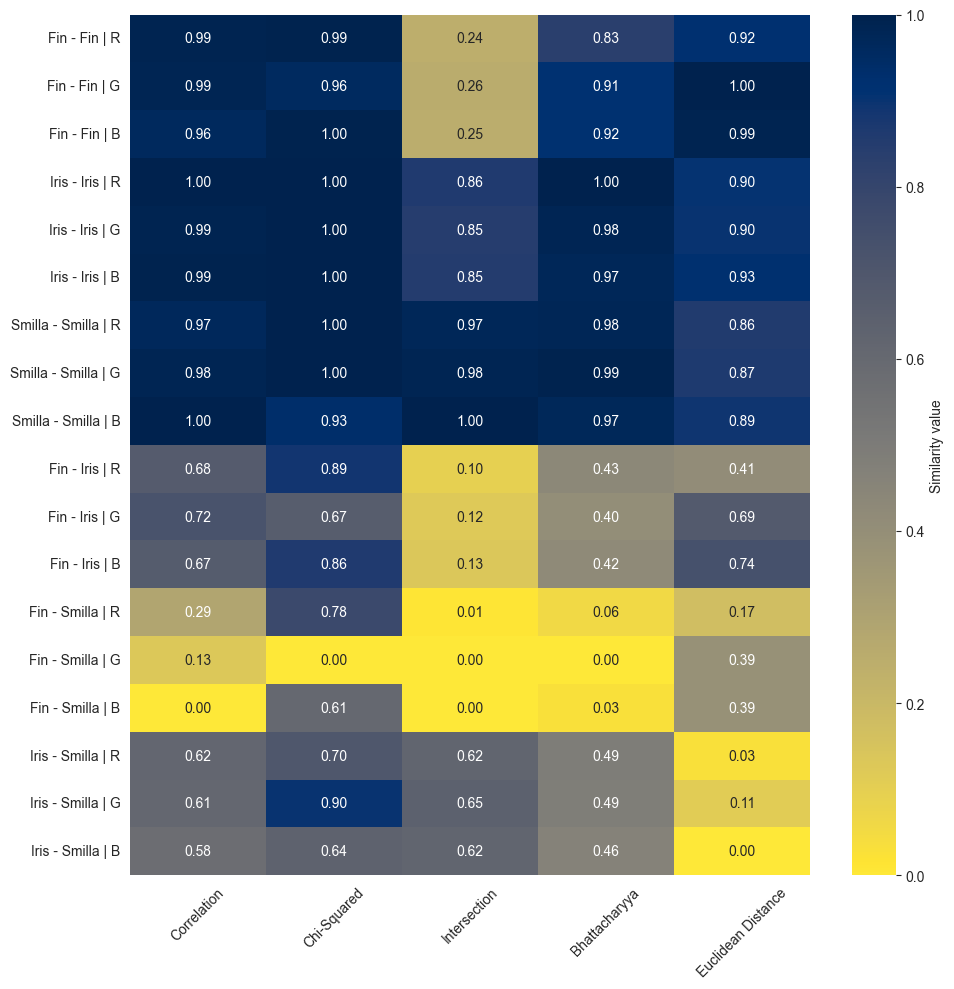

In [23]:
from sklearn.preprocessing import MinMaxScaler

df = pd.DataFrame(comp_results)

for i in range(0, len(df.index)):
    if i == 0:
        # Clipping the correlation results at 0 since the range is -1, 1, with
        # -1 being negative linear correlation and 0 no correlation at all
        scaled = pd.Series(np.clip(df.iloc[i].values, 0, 1), index=df.iloc[i].index)
        scaled = MinMaxScaler((0, 1)).fit_transform(pd.DataFrame(df.iloc[i])).flatten()
        scaled = pd.Series([abs(float(s)) for s in scaled])
        df.iloc[i] = scaled

    elif i in [1, 3, 4]:
        scaled = MinMaxScaler((0, 1)).fit_transform(pd.DataFrame(df.iloc[i])).flatten()
        scaled = pd.Series([1 - float(s) for s in scaled])
        df.iloc[i] = scaled
    else:
        df.iloc[i] = pd.Series(MinMaxScaler((0, 1)).fit_transform(pd.DataFrame(df.iloc[i])).flatten())


plt.figure(figsize = [10, 10])

fig = sns.heatmap(data=df.T, annot=True, fmt='.2f', cbar_kws={'label': 'Similarity value'}, cmap='cividis_r')
plt.xticks(rotation=45)
plt.tight_layout()
if SAVE:
    plt.savefig(f'{output_path}/heatmap_by_channel.png', dpi=150, bbox_inches="tight")
plt.show()


We create a condensed version of the heatmap for reference.

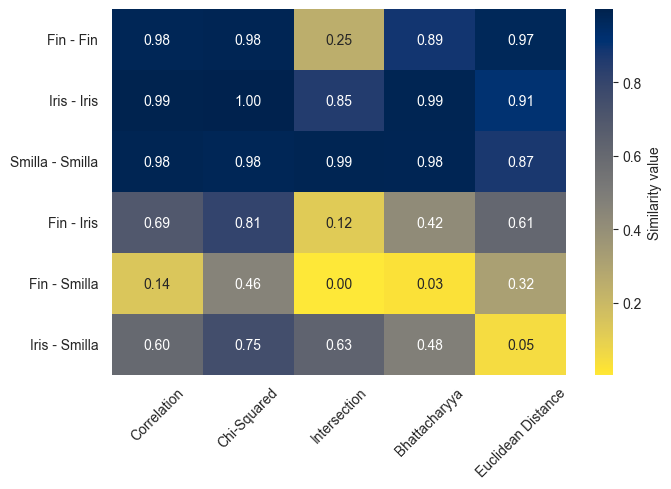

In [24]:
new_index_len = len(df.columns) // 3
df_clean = pd.DataFrame(index=df.index)

for x in range(new_index_len):
    col_name = df.T.index[x*3].split('|')[0]
    col_vals = df.T[x*3:x*3+3].mean(axis=0)
    df_clean[col_name] = col_vals

plt.figure(figsize = [7, 5])
fig = sns.heatmap(data=df_clean.T, annot=True, fmt='.2f', cbar_kws={'label': 'Similarity value'}, cmap='cividis_r')
plt.xticks(rotation=45)
plt.tight_layout()

if SAVE:
    plt.savefig(f'{output_path}/heatmap_conclusion.png', dpi=150, bbox_inches="tight")
plt.show()

    

There are some noticeable patterns regarding the similarity of the pets.<br>
We will note that and come back to it after training the model.

Let's create one last, condensed heatmap showing the mean and median values from all the comparison metrics for each pet pair.

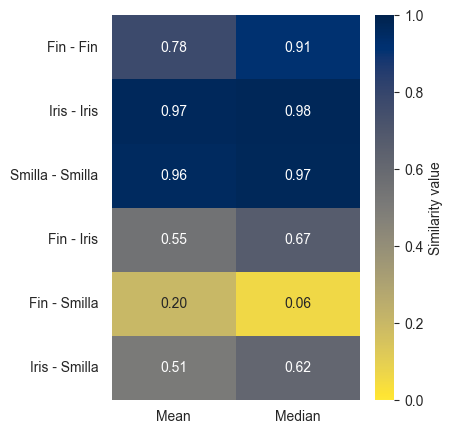

In [76]:

new_index_len = len(df_clean.columns)

# Calculate the mean for each combo and color channel from previous cell result
mean_rows = df_clean[df_clean.columns].mean(axis=0)

# Calculate the median of each combo and color channel from all channel and metric values
median_rows = pd.Series(index=df_clean.columns)
for i in range(new_index_len):
    median_val = np.median(df[df.columns[i*3:i*3+3]].values.flatten())
    median_rows.iloc[i] =  median_val
    
boildown_df = pd.DataFrame(data={'Mean': mean_rows, 'Median': median_rows})

_, ax = plt.subplots(figsize=(4, 5))
ax = sns.heatmap(boildown_df, fmt='.2f', cmap='cividis_r', vmin=0, vmax=1, annot=True, cbar_kws={'label': 'Similarity value'})

if SAVE:
    plt.savefig(f'{output_path}/heatmap_mean_med.png', dpi=150, bbox_inches="tight")
plt.show()

